In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, IntegerType,TimestampType
from pyspark.sql.functions import col, hour

In [2]:
# create schema
schema = StructType([ 
    StructField("dt",TimestampType(), True), 
    StructField("lat",DoubleType(), True), 
    StructField("lon",DoubleType(), True), 
    StructField("base", StringType(), True), 
    StructField("cid", IntegerType(), True),
    StructField("id", StringType(), True),
  ])

In [3]:
spark = SparkSession.builder.appName('Uber').getOrCreate()

22/02/08 17:44:44 WARN Utils: Your hostname, HuyLes-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
22/02/08 17:44:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/08 17:45:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# read data
path = "hdfs://localhost:9000/Uber_Warehouse/transformed/"
df = spark.read.csv(path=path, schema=schema)

df.show(5)
df.printSchema()

+-------------------+-------+--------+------+---+-----------+
|                 dt|    lat|     lon|  base|cid|         id|
+-------------------+-------+--------+------+---+-----------+
|2014-08-05 09:43:00| 40.726|-74.0013|B02682|  0|  0_7260013|
|2014-08-31 07:29:00|40.7546|-73.9895|B02617|  5| 5_75469895|
|2014-08-09 00:16:00|40.6768|-73.9801|B02598|  6| 6_67689801|
|2014-08-17 19:30:00|40.7689|-73.9604|B02617| 10|10_76899604|
|2014-08-01 00:00:00| 40.729|-73.9422|B02598|  7|  7_7299422|
+-------------------+-------+--------+------+---+-----------+
only showing top 5 rows

root
 |-- dt: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)
 |-- cid: integer (nullable = true)
 |-- id: string (nullable = true)



In [5]:
df.count()

829275

### 1. Which clusters had the highest number of pickups?

In [7]:
hight_clus = df.groupBy("cid").count().orderBy(col("count").desc())
hight_clus.show(20)

+---+------+
|cid| count|
+---+------+
|  0|193744|
| 13|118159|
|  5|107348|
| 11|105867|
| 10| 75422|
|  7| 65184|
|  6| 53556|
| 16| 29250|
|  1| 24180|
|  2| 19541|
|  9| 15184|
|  3|  7495|
| 19|  6125|
| 15|  2669|
| 14|  1776|
|  4|  1149|
| 17|  1095|
|  8|   734|
| 12|   488|
| 18|   309|
+---+------+



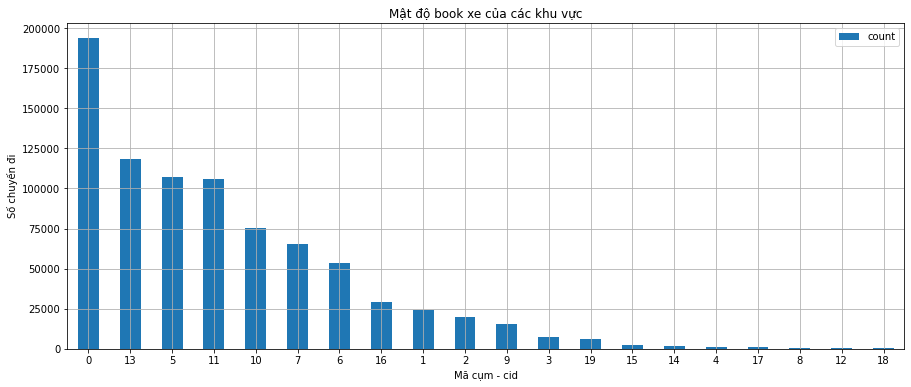

In [10]:
import matplotlib.pyplot as plt
# covert spark df to pandas df
hight_clus_pd = hight_clus.toPandas()

hight_clus_pd.plot.bar(x='cid', y='count', figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Mã cụm - cid")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe của các khu vực");

### 2. Which hours of the day had the highest number of pickups?

In [11]:
hight_hour = df.select(hour("dt").alias("hour")).groupBy("hour").count().orderBy("hour")
hight_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0|21451|
|   1|14471|
|   2|10105|
|   3|10376|
|   4|11774|
|   5|16525|
|   6|24907|
|   7|34064|
|   8|34566|
|   9|30195|
|  10|30706|
|  11|31778|
|  12|32106|
|  13|35764|
|  14|40644|
|  15|48197|
|  16|53481|
|  17|57122|
|  18|55390|
|  19|53008|
|  20|51674|
|  21|51354|
|  22|46008|
|  23|33609|
+----+-----+



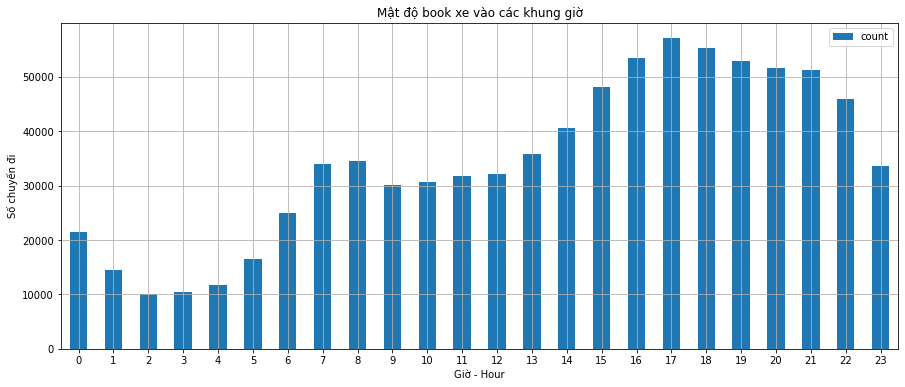

In [12]:
# covert spark df to pandas df
hight_hour_pd = hight_hour.toPandas()

hight_hour_pd.plot.bar(x='hour', y='count', figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe vào các khung giờ");

### 3. Which clusters had the highest number of pickups during morning rush hour?

In [13]:
clus = [0,2,4,7,10,13] # 6 cụm có mật độ cao nhât
hour_mor = [6,7,8,9] # khung giờ buổi sáng

rush_mor = df.select(hour("dt").alias("hour"), "cid").groupBy("hour","cid").count().filter(col("hour").isin(hour_mor) & col("cid").isin(clus)).orderBy("hour", "cid")
rush_mor.show()

+----+---+-----+
|hour|cid|count|
+----+---+-----+
|   6|  0| 5866|
|   6|  2|  676|
|   6|  4|   20|
|   6|  7| 2305|
|   6| 10| 3874|
|   6| 13| 2270|
|   7|  0| 8260|
|   7|  2|  727|
|   7|  4|   35|
|   7|  7| 2758|
|   7| 10| 6115|
|   7| 13| 3679|
|   8|  0| 8671|
|   8|  2|  714|
|   8|  4|   31|
|   8|  7| 2558|
|   8| 10| 5516|
|   8| 13| 4062|
|   9|  0| 6252|
|   9|  2|  744|
+----+---+-----+
only showing top 20 rows



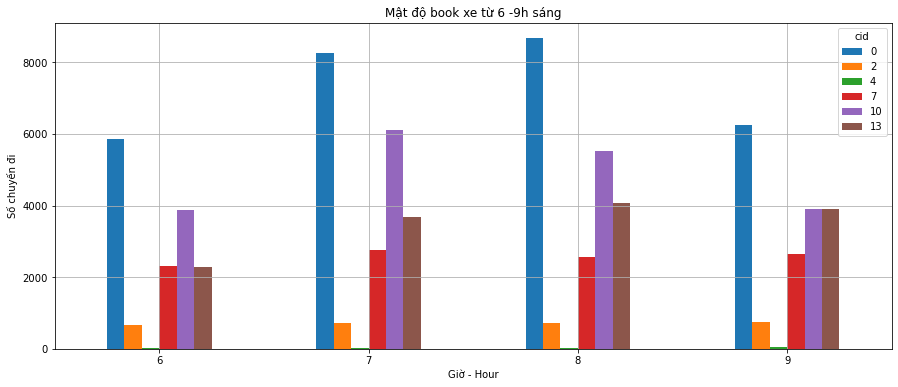

In [14]:
# covert spark df to pandas df
rush_mor_pd = rush_mor.toPandas()
# dùng pivot_table để tổng hợp số cụm và số giờ
rush_mor_pd = rush_mor_pd.pivot_table(index='hour', columns='cid', values='count')

rush_mor_pd.plot.bar(figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe từ 6 -9h sáng");

### 4. Which clusters had the highest number of pickups during afternoon rush hour?

In [15]:
hour_aft = [15,16,17,18] # khung giờ buổi chiều

rush_aft = df.select(hour("dt").alias("hour"), "cid").groupBy("hour","cid").count().filter(col("hour").isin(hour_aft) & col("cid").isin(clus)).orderBy("hour", "cid")
rush_aft.show()

+----+---+-----+
|hour|cid|count|
+----+---+-----+
|  15|  0|10409|
|  15|  2| 1019|
|  15|  4|   61|
|  15|  7| 2686|
|  15| 10| 4220|
|  15| 13| 8637|
|  16|  0|11162|
|  16|  2| 1000|
|  16|  4|   80|
|  16|  7| 2799|
|  16| 10| 4507|
|  16| 13|10412|
|  17|  0|12091|
|  17|  2| 1037|
|  17|  4|   83|
|  17|  7| 3362|
|  17| 10| 4722|
|  17| 13|10601|
|  18|  0|12137|
|  18|  2|  990|
+----+---+-----+
only showing top 20 rows



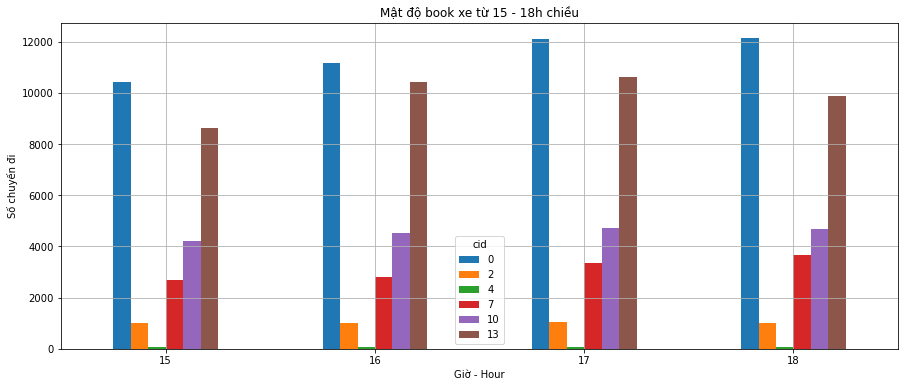

In [16]:
# covert spark df to pandas df
rush_aft_pd = rush_aft.toPandas()
# dùng pivot_table để tổng hợp số cụm và số giờ
rush_aft_pd = rush_aft_pd.pivot_table(index='hour', columns='cid', values='count')

rush_aft_pd.plot.bar(figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe từ 15 - 18h chiều");

### 5. Which clusters had the highest number of pickups during evening rush hour?

In [17]:
hour_eve = [19,20,21,22,23] # khung giờ buổi tối

rush_eve = df.select(hour("dt").alias("hour"), "cid").groupBy("hour","cid").count().filter(col("hour").isin(hour_eve) & col("cid").isin(clus)).orderBy("hour", "cid")
rush_eve.show()

+----+---+-----+
|hour|cid|count|
+----+---+-----+
|  19|  0|12025|
|  19|  2| 1045|
|  19|  4|   67|
|  19|  7| 3689|
|  19| 10| 3822|
|  19| 13| 9096|
|  20|  0|12298|
|  20|  2| 1247|
|  20|  4|   50|
|  20|  7| 3722|
|  20| 10| 3385|
|  20| 13| 7979|
|  21|  0|13078|
|  21|  2| 1369|
|  21|  4|   62|
|  21|  7| 3968|
|  21| 10| 3017|
|  21| 13| 6306|
|  22|  0|12669|
|  22|  2| 1176|
+----+---+-----+
only showing top 20 rows



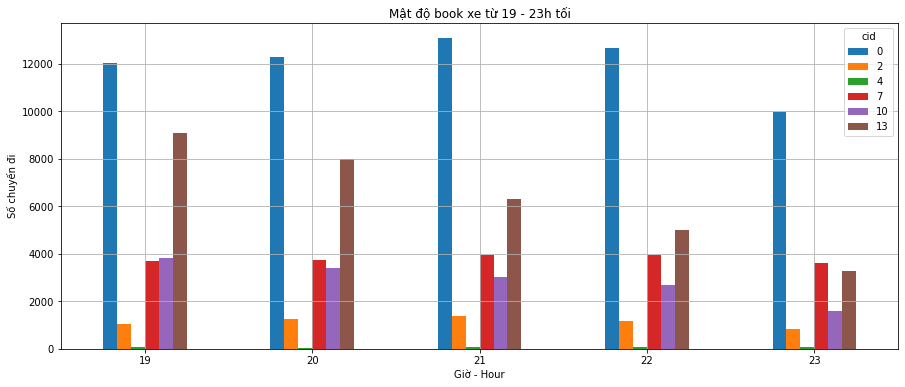

In [18]:
# covert spark df to pandas df
rush_eve_pd = rush_eve.toPandas()
# dùng pivot_table để tổng hợp số cụm và số giờ
rush_eve_pd = rush_eve_pd.pivot_table(index='hour', columns='cid', values='count')

rush_eve_pd.plot.bar(figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe từ 19 - 23h tối");